Let's see if LSI, a common dimensionality reduction method in NLP, can give us any interesting results.

In [1]:
from gensim.models import LsiModel
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
from go_learning_helpers import *
import scipy.sparse as sp
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
file_name = 'kinase_go_processes.csv'
path_to_dir = './'

# get the go annotations
go_annotations = get_go_annotations_series(path_to_dir+file_name)

In [3]:
'''# binarize
lb, go_annotations = convert_go_annotations_to_one_hot(go_annotations,
                                                   return_binarizer= True)'''

'# binarize\nlb, go_annotations = convert_go_annotations_to_one_hot(go_annotations,\n                                                   return_binarizer= True)'

In [4]:
from collections import defaultdict
frequency = defaultdict(int)
for doc in go_annotations:
    for word in doc:
        frequency[word] += 1

texts = [[word for word in doc if frequency[word] > 1]
         for doc in go_annotations]

In [5]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
#dictionary.save('./go.dict')
print(dictionary)

Dictionary(1360 unique tokens: ['actin cytoskeleton organization', 'spermatogenesis', 'DNA damage checkpoint', 'DNA damage induced protein phosphorylation', 'DNA repair']...)


In [6]:
corpus = [dictionary.doc2bow(doc) for doc in texts]
#corpora.MmCorpus.serialize('./go.mm', corpus)

In [7]:
from gensim.models import TfidfModel
tfidf = TfidfModel(corpus)

In [8]:
corpus_tfidf = tfidf[corpus]

In [9]:
'''id_dict = {}
for x in range(len(go_annotations)):
    one_hot_array = np.zeros((len(go_annotations),1))
    one_hot_array.itemset(x, 1)
    id_dict[x] = lb.inverse_transform(one_hot_array)'''

'id_dict = {}\nfor x in range(len(go_annotations)):\n    one_hot_array = np.zeros((len(go_annotations),1))\n    one_hot_array.itemset(x, 1)\n    id_dict[x] = lb.inverse_transform(one_hot_array)'

In [10]:
# binarize
lb, binarized_go_annotations = convert_go_annotations_to_one_hot(go_annotations,
                                                   return_binarizer= True)

go_matrix = np.vstack([x for x in binarized_go_annotations])
go_sparse = sp.csc_matrix(go_matrix.T)

In [11]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components =3)

tsvd.fit(go_matrix.T)

TruncatedSVD(algorithm='randomized', n_components=3, n_iter=5,
       random_state=None, tol=0.0)

In [12]:
a, b = map(np.asarray, zip(*corpus_tfidf[10]))
row = np.repeat(0, len(a))
print(row)
print(a)
print(b)

[0 0 0 0 0 0 0 0 0]
[31 62 83 84 85 86 87 88 89]
[0.17057302 0.31677013 0.31243232 0.1888341  0.53773483 0.30826467
 0.50716529 0.22673494 0.21089818]


In [13]:
len(dictionary)

1360

In [14]:
sp.csc_matrix((b, (row, a)), shape=(1,len(dictionary)))

<1x1360 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Column format>

In [15]:
hold = []
for i in range(473):
    if(len(corpus_tfidf[i]) > 0):
        a, b = map(np.asarray, zip(*corpus_tfidf[i]))
        row = np.repeat(0, len(a))
        hold += [sp.csc_matrix((b, (row, a)), shape=(1,len(dictionary)))]
    else:
        print(i)

190
322
429


In [16]:
tsvd.fit(sp.vstack(hold).toarray().T)

TruncatedSVD(algorithm='randomized', n_components=3, n_iter=5,
       random_state=None, tol=0.0)

In [17]:
tsvd.explained_variance_ratio_

array([0.01545542, 0.01554769, 0.01286735])

In [18]:
mod = LsiModel(corpus=corpus_tfidf, num_topics=2, id2word=dictionary)

In [19]:
mod.print_topics(2)

[(0,
  '-0.283*"intracellular signal transduction" + -0.223*"DNA-templated" + -0.219*"signal transduction by protein phosphorylation" + -0.216*"stress-activated protein kinase signaling cascade" + -0.186*"MAPK cascade" + -0.179*"negative regulation of apoptotic process" + -0.176*"cell differentiation" + -0.161*"apoptotic process" + -0.161*"negative regulation of signal transduction" + -0.156*"positive regulation of ERK1 and ERK2 cascade"'),
 (1,
  '0.317*"negative regulation of signal transduction" + 0.301*"cell differentiation" + -0.286*"stress-activated protein kinase signaling cascade" + -0.277*"signal transduction by protein phosphorylation" + 0.273*"positive regulation of ERK1 and ERK2 cascade" + 0.226*"negative regulation of apoptotic process" + -0.215*"intracellular signal transduction" + 0.194*"ephrin receptor signaling pathway" + -0.189*"activation of JUN kinase activity" + 0.188*"transmembrane receptor protein tyrosine kinase signaling pathway"')]

In [20]:
corpus_lsi = mod[corpus_tfidf]

In [21]:
corpus_lsi.obj.show_topics(2)

[(0,
  '-0.283*"intracellular signal transduction" + -0.223*"DNA-templated" + -0.219*"signal transduction by protein phosphorylation" + -0.216*"stress-activated protein kinase signaling cascade" + -0.186*"MAPK cascade" + -0.179*"negative regulation of apoptotic process" + -0.176*"cell differentiation" + -0.161*"apoptotic process" + -0.161*"negative regulation of signal transduction" + -0.156*"positive regulation of ERK1 and ERK2 cascade"'),
 (1,
  '0.317*"negative regulation of signal transduction" + 0.301*"cell differentiation" + -0.286*"stress-activated protein kinase signaling cascade" + -0.277*"signal transduction by protein phosphorylation" + 0.273*"positive regulation of ERK1 and ERK2 cascade" + 0.226*"negative regulation of apoptotic process" + -0.215*"intracellular signal transduction" + 0.194*"ephrin receptor signaling pathway" + -0.189*"activation of JUN kinase activity" + 0.188*"transmembrane receptor protein tyrosine kinase signaling pathway"')]

190
322
429


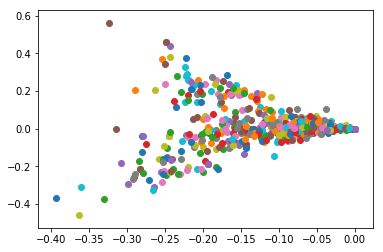

In [22]:
fig, ax = plt.subplots()
for i in range(473):
    try:
        ax.scatter(x=corpus_lsi[i][0][1], y = corpus_lsi[i][1][1])
    except:
        print(i)

In [23]:
mod_3 = LsiModel(corpus=corpus_tfidf, num_topics=3, id2word=dictionary)

In [24]:
corpus_lsi_3 = mod_3[corpus_tfidf]

In [25]:
corpus_lsi_3.obj.show_topics(3)

[(0,
  '-0.283*"intracellular signal transduction" + -0.223*"DNA-templated" + -0.219*"signal transduction by protein phosphorylation" + -0.216*"stress-activated protein kinase signaling cascade" + -0.185*"MAPK cascade" + -0.179*"negative regulation of apoptotic process" + -0.176*"cell differentiation" + -0.162*"apoptotic process" + -0.161*"negative regulation of signal transduction" + -0.156*"positive regulation of ERK1 and ERK2 cascade"'),
 (1,
  '0.317*"negative regulation of signal transduction" + 0.301*"cell differentiation" + -0.285*"stress-activated protein kinase signaling cascade" + -0.277*"signal transduction by protein phosphorylation" + 0.274*"positive regulation of ERK1 and ERK2 cascade" + 0.227*"negative regulation of apoptotic process" + -0.216*"intracellular signal transduction" + 0.194*"ephrin receptor signaling pathway" + -0.191*"activation of JUN kinase activity" + 0.187*"transmembrane receptor protein tyrosine kinase signaling pathway"'),
 (2,
  '-0.483*"intracellula

In [26]:
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(473):
    try:
        ax.scatter(corpus_lsi_3[i][0][1], corpus_lsi_3[i][1][1], corpus_lsi_3[i][2][1])
    except:
        print(i)

<IPython.core.display.Javascript object>

190
322
429


In [27]:
ind = go_annotations.index.tolist()

In [28]:
corpus_lsi_3[0]

[(0, -0.06323832969889413),
 (1, 0.02467261790077276),
 (2, -0.05468316130908846)]

In [29]:
consensus_file_name = 'consensusclusters_spinglass_greaterthan90percent.txt'
path_to_consensus = '../results/'

consensus_dat = add_cluster_labels(path_to_consensus+consensus_file_name,
                                  go_annotations)

print(consensus_dat.head(5))

Dropped  0 kinases due to zero length post-processing
       cluster                                          GO Labels
names                                                            
PAK1         1  [positive regulation of JUN kinase activity, n...
ERBB2        2  [negative regulation of ERBB signaling pathway...
RON          3  [positive regulation of MAP kinase activity, p...
YES          3  [cellular protein modification process, Fc-gam...
TYRO3        3  [viral entry into host cell, vagina developmen...


In [30]:
x_coords = [corpus_lsi_3[x][0][1] for x in range(473) if len(corpus_lsi_3[x])>1]
y_coords = [corpus_lsi_3[x][1][1] for x in range(473) if len(corpus_lsi_3[x])>1]
z_coords = [corpus_lsi_3[x][2][1] for x in range(473) if len(corpus_lsi_3[x])>1]

In [31]:
colors = [consensus_dat['cluster'].loc[ind[x]] for x in range(473) if x != 337]

In [32]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coords, y_coords, z_coords, alpha = 0.9, c=colors, cmap='viridis_r')

<IPython.core.display.Javascript object>

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
fast_greedy_file_name = 'fastgreedy_clusters.txt'
path_to_fast_greedy = '../results/'

fast_greedy_dat = add_cluster_labels(path_to_fast_greedy+fast_greedy_file_name,
                                  go_annotations)

print(fast_greedy_dat.head(5))

In [ ]:
colors = [fast_greedy_dat['cluster'].loc[ind[x]] for x in range(473) if x != 337]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coords, y_coords, z_coords, alpha = 0.9, c=colors, cmap='jet_r')

for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

In [ ]:
lsi_dat = pd.DataFrame(np.vstack([np.asarray(x_coords).reshape(1,472),np.asarray(y_coords).reshape(1,472), np.asarray(z_coords).reshape(1,472)]).T)

In [ ]:
lsi_dat.index = [y for x, y in enumerate(ind) if x != 163]

In [ ]:
lsi_dat.head()

In [ ]:
consensus_file_name = 'consensusclusters_spinglass_greaterthan90percent.txt'
path_to_consensus = '../results/'

consensus_lsi = add_cluster_labels(path_to_consensus+consensus_file_name,
                                  lsi_dat)

print(consensus_lsi.head(5))
consensus_lsi.dropna(inplace=True, axis=0)

In [ ]:
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.naive_bayes import ComplementNB as CNB

svm = SVC(kernel='linear')
nb = GNB()
#cnb = CNB()

classifiers = [svm, nb]#, cnb]

In [ ]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(consensus_lsi[[0,1,2]].values.tolist(), consensus_lsi['cluster'].values.tolist(), test_size=0.3)

for clf in classifiers:
    clf.fit(X_train, y_train);

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test)))

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test), 'matthews'))

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test), 'cohen'))

In [ ]:
fast_greedy_file_name = 'fastgreedy_clusters.txt'
path_to_fast_greedy = '../results/'

fast_greedy_lsi = add_cluster_labels(path_to_fast_greedy+fast_greedy_file_name,
                                  lsi_dat)

fast_greedy_lsi.dropna(inplace=True, axis=0)
print(fast_greedy_lsi.head(5))

In [ ]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(fast_greedy_lsi[[0,1,2]].values.tolist(), fast_greedy_lsi['cluster'].values.tolist(), test_size=0.3)

for clf in classifiers:
    clf.fit(X_train, y_train);

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test)))

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test), 'matthews'))

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test), 'cohen'))

In [ ]:
mod_50 = LsiModel(corpus=corpus_tfidf, num_topics=50, id2word=dictionary)

In [ ]:
corpus_lsi_50 = mod_50[corpus_tfidf]

In [ ]:
from sklearn.manifold import TSNE

t = TSNE(n_components=3)

In [ ]:
corpus_lsi_50[1][48][1]

In [ ]:
holder = []
for x in range(473):
    if(len(corpus_lsi_50[x])>1):
        holder.append([corpus_lsi_50[x][i][1] for i in range(50)])

In [ ]:
np.vstack(map(np.array, holder)).shape

In [ ]:
new_dat = t.fit_transform(np.vstack(map(np.array, holder)))

In [ ]:
x_coords = [coord[0] for coord in new_dat]
y_coords = [coord[1] for coord in new_dat]
z_coords = [coord[2] for coord in new_dat]

In [ ]:
colors = [fast_greedy_dat['cluster'].loc[ind[x]] for x in range(473) if x != 337]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coords, y_coords, z_coords, alpha = 0.9, c=colors, cmap='jet_r')

In [ ]:
from sklearn.manifold import Isomap

iso = Isomap(n_components=3)

In [ ]:
new_dat_iso = iso.fit_transform(np.vstack(map(np.array, holder)))

In [ ]:
x_coords = [coord[0] for coord in new_dat_iso]
y_coords = [coord[1] for coord in new_dat_iso]
z_coords = [coord[2] for coord in new_dat_iso]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coords, y_coords, z_coords, alpha = 0.9, c=colors, cmap='jet_r')

In [ ]:
import umap

In [ ]:
fitter = umap.UMAP(metric='cosine')

In [ ]:
preds = fitter.fit_transform(np.vstack(map(np.array, holder)))

In [ ]:
x_coords = [coord[0] for coord in preds]
y_coords = [coord[1] for coord in preds]

In [ ]:
from collections import Counter
c = Counter(colors)
filter(lambda x: c[x] > 1, 
__, filtered_x = zip(*list(zip(colors, x_coords)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x_coords, y_coords, alpha = 0.9, c=colors, cmap='magma_r')